# Double integration

In [1]:
%matplotlib notebook
from speed_regression import training_data as td
from speed_regression import imu_optimization as imu_optimization
import numpy as np
import pandas
import sklearn.svm as svm
from sklearn.externals import joblib
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import quaternion

import algorithms.double_integration as double_integration

nano_to_sec = 1e09

# configure the size of plot
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

## Test linear acceleration signal

<IPython.core.display.Javascript object>


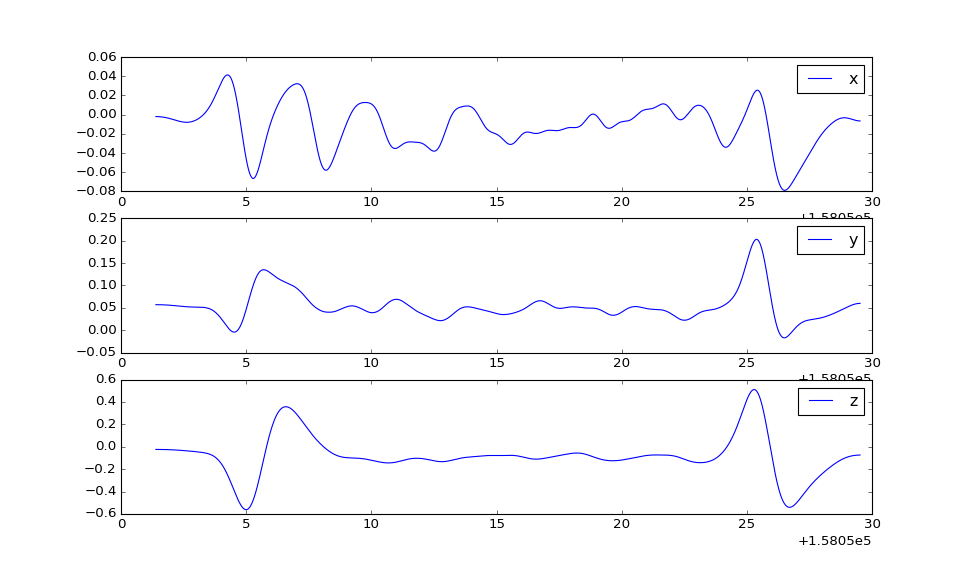

In [8]:
test_data_all = pandas.read_csv('../../data/test_line1/processed/data.csv')
linacce = test_data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
time_stamp = test_data_all['time'].values / nano_to_sec

linacce = gaussian_filter1d(linacce, axis=0, sigma=50.0)
axis_names = 'xyz'
plt.figure()
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, linacce[:, i])
    plt.legend(axis_names[i])

<IPython.core.display.Javascript object>


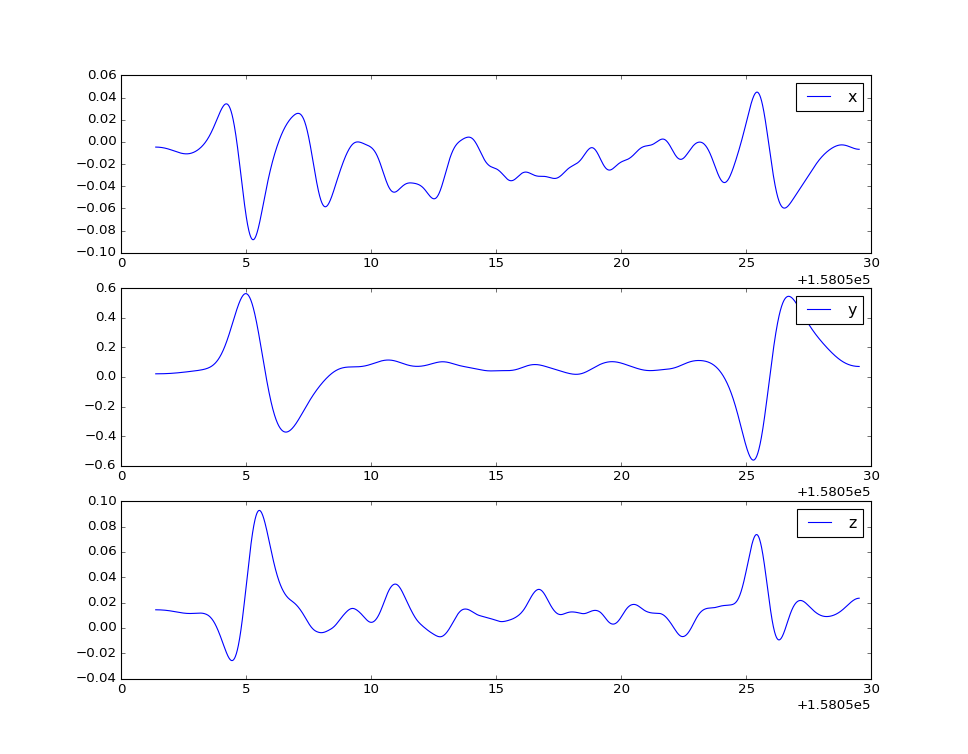

In [6]:
rotations = test_data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values
linacce = test_data_all[['linacce_x', 'linacce_y', 'linacce_z']].values

quats = quaternion.as_quat_array(rotations)
linacce_rot = np.array([np.dot(quaternion.as_rotation_matrix(quats[i]), linacce[i])
                        for i in range(quats.shape[0])])

linacce_rot = gaussian_filter1d(linacce_rot, axis=0, sigma=50.0)
axis_names = 'xyz'
plt.figure()
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, linacce_rot[:, i])
    plt.legend(axis_names[i])

# IMU Calibration

## IMU Optimization

<IPython.core.display.Javascript object>


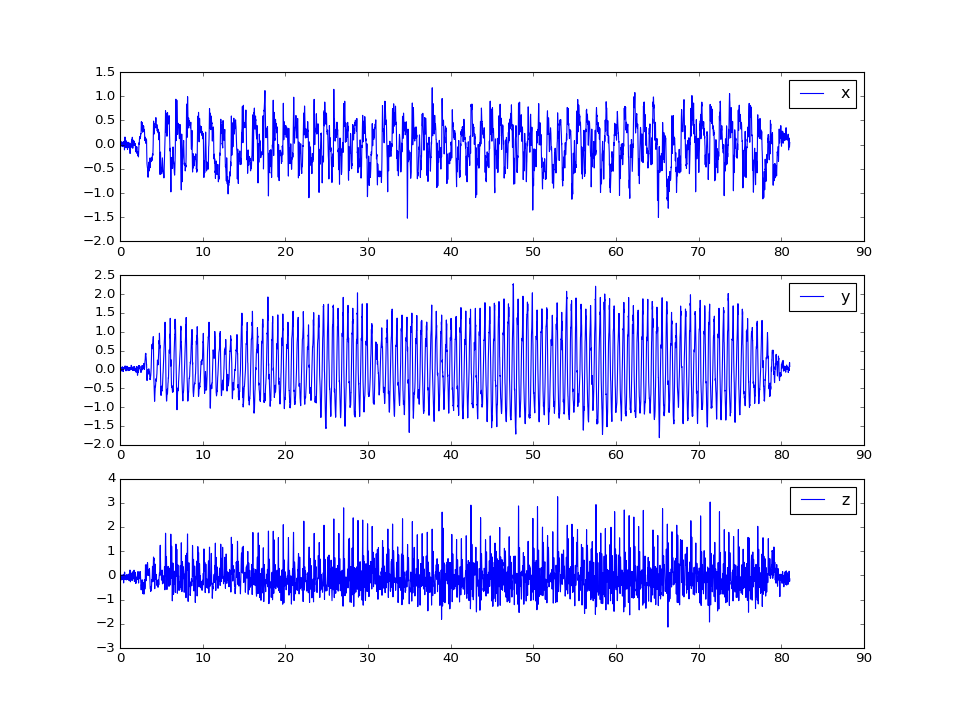

Optimizing acceleration bias
`ftol` termination condition is satisfied.
Function evaluations 60, initial cost 5.4847e-01, final cost 6.5743e-03, first-order optimality 4.45e-07.


<IPython.core.display.Javascript object>


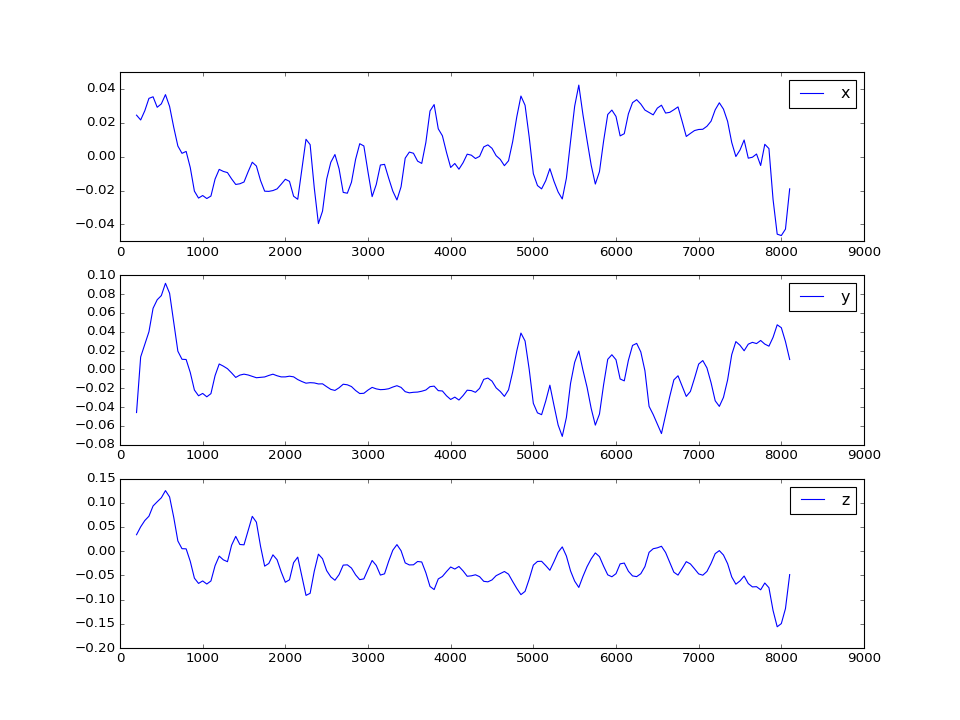

<IPython.core.display.Javascript object>


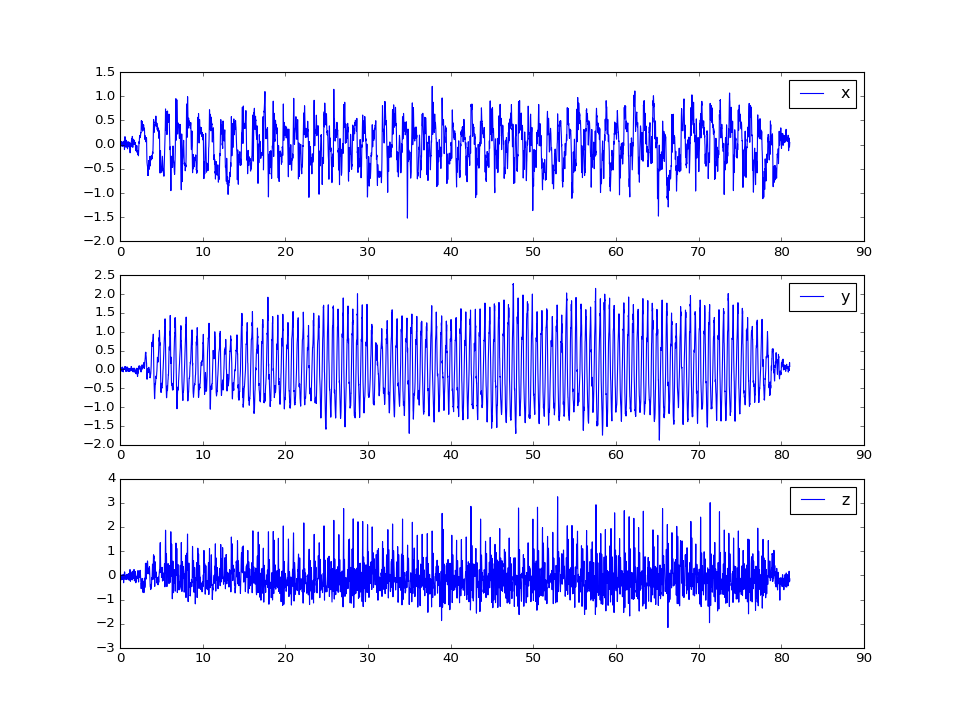

<IPython.core.display.Javascript object>


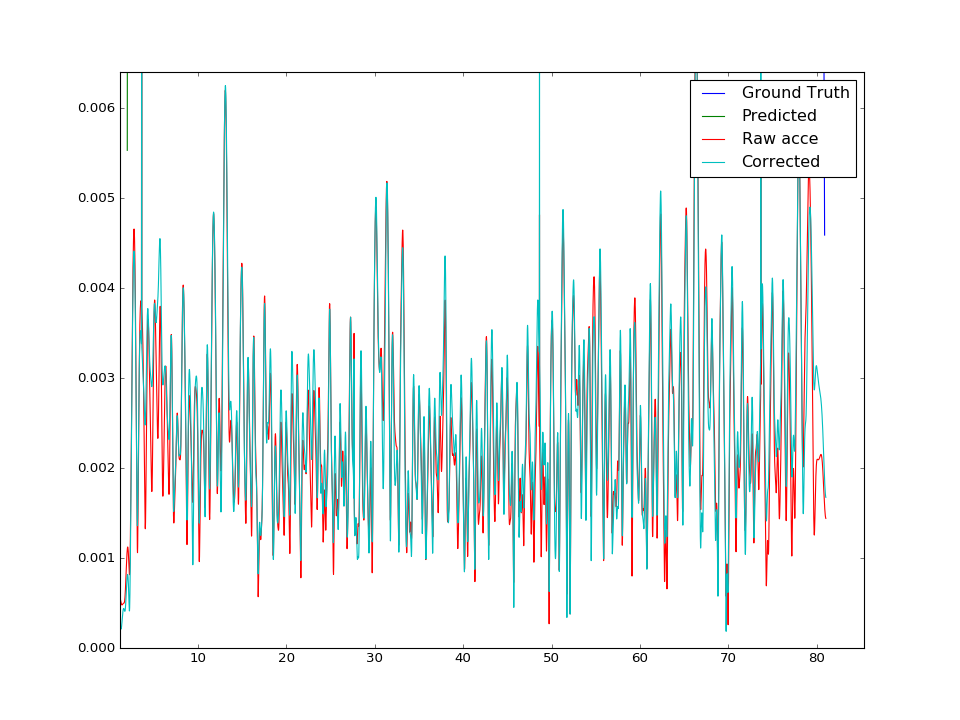

In [3]:
data_all = pandas.read_csv('../../data/20170126025407/processed/data.csv')
time_stamp = data_all['time'].values / nano_to_sec
time_stamp -= time_stamp[0]
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']
options = td.TrainingDataOption(feature='fourier', window_size=200, frq_threshold=100, sample_step=50)
speed_ind = np.arange(options.window_size_, data_all.shape[0] - 1, options.sample_step_, dtype=int)
variable_ind = speed_ind.copy()
variable_ind[-1] += 1

linacce = data_all[['linacce_x', 'linacce_y', 'linacce_z']].values
orientation = data_all[['ori_w', 'ori_x', 'ori_y', 'ori_z']].values

test_data = td.get_training_data(data_all=data_all, imu_columns=imu_columns,
                                 option=options, sample_points=speed_ind)

regressor = joblib.load('../../models/model_walk_fourier_w200_s10.svm')
predicted_speed = regressor.predict(test_data[:, :-1])

param = {'sigma_a': 1.0, 'sigma_s': 0.1}

axis_legend = 'xyz'
plt.figure('Raw acceleration')
plt.title('Raw Acceleration')    
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, linacce[:, i])
    plt.legend(axis_legend[i])

print('Optimizing acceleration bias')
optimizer, corrected = imu_optimization.optimize_linear_acceleration(time_stamp=time_stamp,
                                                                     linacce=linacce,
                                                                     orientation=orientation,
                                                                     speed_ind=speed_ind,
                                                                     sparse_location=variable_ind,
                                                                     regressed_speed=predicted_speed,
                                                                     param=param,
                                                                     verbose=1)

bias = optimizer.x.reshape([-1, 3])
plt.figure('Bias') 
plt.title('Estimated Bias')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(variable_ind, bias[:, i])
    plt.legend(axis_legend[i])

plt.figure('Corrected acceleration')
plt.title('Corrected acceleration')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(time_stamp, corrected[:, i])
    plt.legend(axis_legend[i])
    
# Compute the speed before and after optimization
filter_sigma = 20.0
# transform raw acceleration into the global frame
for i in range(linacce.shape[0]):
    rot = quaternion.as_rotation_matrix(quaternion.quaternion(*orientation[i]))
    linacce[i] = np.dot(rot, linacce[i].transpose()).flatten()
    
raw_acceleration = gaussian_filter1d(linacce, sigma=filter_sigma, axis=0)
# corrected acceleration is already inside the global frame, no need for transformation
corrected = gaussian_filter1d(corrected, sigma=filter_sigma, axis=0)

time_interval = (time_stamp[1:] - time_stamp[:-1])[:, None]
speed_raw = (raw_acceleration[1:] + raw_acceleration[:-1]) * time_interval / 2.0
speed_corrected = (corrected[1:] + corrected[:-1]) * time_interval / 2.0
init_speed = np.array([[0., 0., 0.]])
speed_raw = np.concatenate([init_speed, speed_raw], axis=0)
speed_corrected = np.concatenate([init_speed, speed_corrected], axis=0)

plt.figure('Speed')
plt.plot(time_stamp[speed_ind], test_data[:, -1])
plt.plot(time_stamp[speed_ind], predicted_speed)
plt.plot(time_stamp, np.linalg.norm(speed_raw, axis=1))
plt.plot(time_stamp, np.linalg.norm(speed_corrected, axis=1))
plt.legend(['Ground Truth', 'Predicted', 'Raw acce', 'Corrected'])
